In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, f1_score, precision_score
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

import warnings
# Ignore PerformanceWarnings specifically
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=Warning)  # Ignore Perform

In [2]:
file_path = "/kaggle/input/data-storm-6-0/sample_submission_storming_round.csv" 
sub = pd.read_csv(file_path)

In [3]:
file_path = "/kaggle/input/data-storm-6-0/train_storming_round.csv" 
train = pd.read_csv(file_path)

In [4]:
file_path = "/kaggle/input/data-storm-6-0/test_storming_round.csv" 
test = pd.read_csv(file_path)

In [5]:
ids = test['row_id']
train = train.drop(columns=['row_id'], axis=1)
test = test.drop(columns=['row_id'], axis=1)

In [6]:
train = train.drop_duplicates()

In [7]:
train['year_month'] = pd.to_datetime(train['year_month'], format='%m/%d/%Y')
test['year_month'] = pd.to_datetime(test['year_month'], format='%m/%d/%Y')
train['agent_join_month'] = pd.to_datetime(train['agent_join_month'], format='%m/%d/%Y')
test['agent_join_month'] = pd.to_datetime(test['agent_join_month'], format='%m/%d/%Y')
train['first_policy_sold_month'] = pd.to_datetime(train['first_policy_sold_month'], format='%m/%d/%Y')
test['first_policy_sold_month'] = pd.to_datetime(test['first_policy_sold_month'], format='%m/%d/%Y')

In [8]:
merged_df = pd.concat([train, test], axis=0).reset_index(drop=True)

In [9]:
agents_to_remove = {'f9f0169c', 'c37f2ebf', '421aec8b', '6a0d02ea', '5444f88c', '335b4b20', '3f4c6d56', 'b5338672', 'd8e13589'}
merged_df = merged_df[~merged_df['agent_code'].isin(agents_to_remove)].reset_index(drop=True)
merged_df

,agent_code,agent_age,agent_join_month,first_policy_sold_month,year_month,unique_proposals_last_7_days,unique_proposals_last_15_days,unique_proposals_last_21_days,unique_proposal,unique_quotations_last_7_days,...,unique_quotations,unique_customers_last_7_days,unique_customers_last_15_days,unique_customers_last_21_days,unique_customers,new_policy_count,ANBP_value,net_income,number_of_policy_holders,number_of_cash_payment_policies
0,455ca878,45,2021-02-01,2023-09-01,2023-01-01,3,6,2,12,3,...,9,3,4,8,15,0,0,93313,30,162
1,c823ce77,48,2022-04-01,2024-02-01,2023-01-01,1,4,12,21,3,...,14,4,3,10,17,25,1071450,164804,0,175
2,62154055,53,2020-05-01,2023-09-01,2023-01-01,3,5,5,17,1,...,14,3,7,11,21,26,1601210,426690,84,78
3,c58bfa6e,44,2019-07-01,2022-03-01,2023-01-01,1,0,12,17,1,...,11,2,2,9,13,18,283230,47793,39,144
4,b1e5f770,20,2020-09-01,2023-02-01,2023-01-01,0,6,10,17,3,...,13,3,10,6,19,20,1957680,562239,19,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16208,8f77f8e4,55,2020-05-01,2022-01-01,2024-09-01,2,1,11,16,4,...,15,4,3,7,14,21,1143954,313127,14,21
16209,a199082b,60,2021-10-01,2022-11-01,2024-09-01,2,1,15,21,2,...,19,2,4,2,8,26,2169310,267832,8,78
16210,9c2e3be7,45,2022-07-01,2023-07-01,2024-09-01,3,5,14,27,2,...,23,3,2,10,15,34,1980194,449309,60,238
16211,89cb3dd5,23,2021-05-01,2023-06-01,2024-09-01,3,5,7,19,3,...,10,3,7,3,13,28,2489004,462418,13,56


In [10]:
test

,agent_code,agent_age,agent_join_month,first_policy_sold_month,year_month,unique_proposals_last_7_days,unique_proposals_last_15_days,unique_proposals_last_21_days,unique_proposal,unique_quotations_last_7_days,...,unique_quotations,unique_customers_last_7_days,unique_customers_last_15_days,unique_customers_last_21_days,unique_customers,new_policy_count,ANBP_value,net_income,number_of_policy_holders,number_of_cash_payment_policies
0,de9a845f,43,2020-06-01,2022-04-01,2024-09-01,0,2,12,17,4,...,14,6,9,5,20,24,511320,86955,0,48
1,1450745b,32,2019-05-01,2022-08-01,2024-09-01,1,3,4,13,0,...,12,2,2,5,9,14,296660,55062,9,56
2,5c4dd08c,52,2019-06-01,2022-06-01,2024-09-01,2,6,17,27,3,...,21,5,6,10,21,34,833544,224429,0,34
3,3c7a8b50,21,2021-05-01,2023-09-01,2024-09-01,1,6,17,26,3,...,15,3,2,10,15,33,2972409,439159,15,33
4,3dd0c2a1,33,2022-09-01,2023-11-01,2024-09-01,0,4,2,8,3,...,14,5,4,6,15,15,168150,18195,60,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909,8f77f8e4,55,2020-05-01,2022-01-01,2024-09-01,2,1,11,16,4,...,15,4,3,7,14,21,1143954,313127,14,21
910,a199082b,60,2021-10-01,2022-11-01,2024-09-01,2,1,15,21,2,...,19,2,4,2,8,26,2169310,267832,8,78
911,9c2e3be7,45,2022-07-01,2023-07-01,2024-09-01,3,5,14,27,2,...,23,3,2,10,15,34,1980194,449309,60,238
912,89cb3dd5,23,2021-05-01,2023-06-01,2024-09-01,3,5,7,19,3,...,10,3,7,3,13,28,2489004,462418,13,56


In [11]:
train_sorted = merged_df.sort_values(by=['agent_code', 'year_month']).copy()
train_sorted

,agent_code,agent_age,agent_join_month,first_policy_sold_month,year_month,unique_proposals_last_7_days,unique_proposals_last_15_days,unique_proposals_last_21_days,unique_proposal,unique_quotations_last_7_days,...,unique_quotations,unique_customers_last_7_days,unique_customers_last_15_days,unique_customers_last_21_days,unique_customers,new_policy_count,ANBP_value,net_income,number_of_policy_holders,number_of_cash_payment_policies
8,003c1999,35,2020-08-01,2022-12-01,2023-01-01,2,2,0,8,0,...,2,2,2,1,5,0,0,327407,5,0
958,003c1999,35,2020-08-01,2022-12-01,2023-02-01,3,2,20,30,0,...,14,2,5,12,19,31,2408297,408662,57,217
1761,003c1999,35,2020-08-01,2022-12-01,2023-03-01,0,2,19,23,2,...,19,4,5,11,20,27,1901097,287226,20,243
2577,003c1999,35,2020-08-01,2022-12-01,2023-04-01,2,6,11,21,3,...,19,4,9,7,20,22,1635788,381203,60,176
2708,003c1999,35,2020-08-01,2022-12-01,2023-05-01,3,3,7,15,4,...,14,4,6,8,18,20,1876640,471548,0,180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12008,fffb525d,32,2020-03-01,2023-11-01,2024-05-01,0,6,12,23,0,...,21,1,4,6,11,29,1367553,316643,0,29
12950,fffb525d,32,2020-03-01,2023-11-01,2024-06-01,2,6,5,14,1,...,12,3,9,6,18,0,0,118609,54,184
13905,fffb525d,32,2020-03-01,2023-11-01,2024-07-01,1,1,20,27,0,...,22,0,2,9,11,33,117810,24775,33,264
14569,fffb525d,32,2020-03-01,2023-11-01,2024-08-01,2,1,14,18,4,...,17,6,6,14,26,21,1649298,290164,0,84


In [12]:
train_shifted = train_sorted.copy()

In [13]:
# Group by agent_code and shift new_policy_count upward
train_shifted['next_month_new_policy_count'] = train_shifted.groupby('agent_code')['new_policy_count'].shift(-1)

In [14]:
# Identify the last row per agent_code group
last_rows = train_shifted.groupby('agent_code').tail(1)

# Remove those rows from train_shifted
train_shifted = train_shifted.drop(last_rows.index)

In [15]:
train_shifted['next_month_new_policy_count'] = (train_shifted['next_month_new_policy_count'] != 0).astype(int)
train_shifted

,agent_code,agent_age,agent_join_month,first_policy_sold_month,year_month,unique_proposals_last_7_days,unique_proposals_last_15_days,unique_proposals_last_21_days,unique_proposal,unique_quotations_last_7_days,...,unique_customers_last_7_days,unique_customers_last_15_days,unique_customers_last_21_days,unique_customers,new_policy_count,ANBP_value,net_income,number_of_policy_holders,number_of_cash_payment_policies,next_month_new_policy_count
8,003c1999,35,2020-08-01,2022-12-01,2023-01-01,2,2,0,8,0,...,2,2,1,5,0,0,327407,5,0,1
958,003c1999,35,2020-08-01,2022-12-01,2023-02-01,3,2,20,30,0,...,2,5,12,19,31,2408297,408662,57,217,1
1761,003c1999,35,2020-08-01,2022-12-01,2023-03-01,0,2,19,23,2,...,4,5,11,20,27,1901097,287226,20,243,1
2577,003c1999,35,2020-08-01,2022-12-01,2023-04-01,2,6,11,21,3,...,4,9,7,20,22,1635788,381203,60,176,1
2708,003c1999,35,2020-08-01,2022-12-01,2023-05-01,3,3,7,15,4,...,4,6,8,18,20,1876640,471548,0,180,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10976,fffb525d,32,2020-03-01,2023-11-01,2024-04-01,2,6,7,17,1,...,1,9,9,19,25,557100,100780,57,75,1
12008,fffb525d,32,2020-03-01,2023-11-01,2024-05-01,0,6,12,23,0,...,1,4,6,11,29,1367553,316643,0,29,0
12950,fffb525d,32,2020-03-01,2023-11-01,2024-06-01,2,6,5,14,1,...,3,9,6,18,0,0,118609,54,184,1
13905,fffb525d,32,2020-03-01,2023-11-01,2024-07-01,1,1,20,27,0,...,0,2,9,11,33,117810,24775,33,264,1


In [16]:
test

,agent_code,agent_age,agent_join_month,first_policy_sold_month,year_month,unique_proposals_last_7_days,unique_proposals_last_15_days,unique_proposals_last_21_days,unique_proposal,unique_quotations_last_7_days,...,unique_quotations,unique_customers_last_7_days,unique_customers_last_15_days,unique_customers_last_21_days,unique_customers,new_policy_count,ANBP_value,net_income,number_of_policy_holders,number_of_cash_payment_policies
0,de9a845f,43,2020-06-01,2022-04-01,2024-09-01,0,2,12,17,4,...,14,6,9,5,20,24,511320,86955,0,48
1,1450745b,32,2019-05-01,2022-08-01,2024-09-01,1,3,4,13,0,...,12,2,2,5,9,14,296660,55062,9,56
2,5c4dd08c,52,2019-06-01,2022-06-01,2024-09-01,2,6,17,27,3,...,21,5,6,10,21,34,833544,224429,0,34
3,3c7a8b50,21,2021-05-01,2023-09-01,2024-09-01,1,6,17,26,3,...,15,3,2,10,15,33,2972409,439159,15,33
4,3dd0c2a1,33,2022-09-01,2023-11-01,2024-09-01,0,4,2,8,3,...,14,5,4,6,15,15,168150,18195,60,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909,8f77f8e4,55,2020-05-01,2022-01-01,2024-09-01,2,1,11,16,4,...,15,4,3,7,14,21,1143954,313127,14,21
910,a199082b,60,2021-10-01,2022-11-01,2024-09-01,2,1,15,21,2,...,19,2,4,2,8,26,2169310,267832,8,78
911,9c2e3be7,45,2022-07-01,2023-07-01,2024-09-01,3,5,14,27,2,...,23,3,2,10,15,34,1980194,449309,60,238
912,89cb3dd5,23,2021-05-01,2023-06-01,2024-09-01,3,5,7,19,3,...,10,3,7,3,13,28,2489004,462418,13,56


In [17]:
test_shifted = test.copy()

In [18]:
train_shifted['agent_join_year'] = train_shifted['agent_join_month'].dt.year
train_shifted['agent_join_month_num'] = train_shifted['agent_join_month'].dt.month

train_shifted['first_policy_sold_year'] = train_shifted['first_policy_sold_month'].dt.year
train_shifted['first_policy_sold_month_num'] = train_shifted['first_policy_sold_month'].dt.month

train_shifted['year'] = train_shifted['year_month'].dt.year
train_shifted['month'] = train_shifted['year_month'].dt.month

# Drop original datetime columns
train_shifted = train_shifted.drop(columns=['agent_join_month', 'first_policy_sold_month', 'year_month'])

In [19]:
test_shifted['agent_join_year'] = test_shifted['agent_join_month'].dt.year
test_shifted['agent_join_month_num'] = test_shifted['agent_join_month'].dt.month

test_shifted['first_policy_sold_year'] = test_shifted['first_policy_sold_month'].dt.year
test_shifted['first_policy_sold_month_num'] = test_shifted['first_policy_sold_month'].dt.month

test_shifted['year'] = test_shifted['year_month'].dt.year
test_shifted['month'] = test_shifted['year_month'].dt.month

# Drop original datetime columns
test_shifted = test_shifted.drop(columns=['agent_join_month', 'first_policy_sold_month', 'year_month'])

In [20]:
train_shifted['join_duration'] = (train_shifted['year'] - train_shifted['agent_join_year'])*12 + (train_shifted['month'] - train_shifted['agent_join_month_num'])
train_shifted['time_to_sell'] = (train_shifted['first_policy_sold_year'] - train_shifted['agent_join_year'])*12 + (train_shifted['first_policy_sold_month_num'] - train_shifted['agent_join_month_num'])

In [21]:
test_shifted['join_duration'] = (test_shifted['year'] - test_shifted['agent_join_year'])*12 + (test_shifted['month'] - test_shifted['agent_join_month_num'])
test_shifted['time_to_sell'] = (test_shifted['first_policy_sold_year'] - test_shifted['agent_join_year'])*12 + (test_shifted['first_policy_sold_month_num'] - test_shifted['agent_join_month_num'])

In [22]:
train_shifted['proposals_trend'] = train_shifted['unique_proposals_last_7_days'] - train_shifted['unique_proposals_last_15_days']
train_shifted['quotations_trend'] = train_shifted['unique_quotations_last_7_days'] - train_shifted['unique_quotations_last_15_days']
train_shifted['customers_trend'] = train_shifted['unique_customers_last_7_days'] - train_shifted['unique_customers_last_15_days']

In [23]:
test_shifted['proposals_trend'] = test_shifted['unique_proposals_last_7_days'] - test_shifted['unique_proposals_last_15_days']
test_shifted['quotations_trend'] = test_shifted['unique_quotations_last_7_days'] - test_shifted['unique_quotations_last_15_days']
test_shifted['customers_trend'] = test_shifted['unique_customers_last_7_days'] - test_shifted['unique_customers_last_15_days']

In [24]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

train_shifted['agent_code'] = le.fit_transform(train_shifted['agent_code'])

In [25]:
# Create a mapping dictionary
label_map = dict(zip(le.classes_, le.transform(le.classes_)))

# Apply the mapping to test data, assign -1 to unseen agent_codes
test_shifted['agent_code'] = test_shifted['agent_code'].map(label_map).fillna(-1).astype(int)

In [26]:
cols_to_normalize = [
    'unique_proposals_last_7_days',
    'unique_proposal',
    'unique_quotations_last_7_days',
    'unique_quotations',
    'unique_customers_last_7_days',
    'unique_customers',
    'number_of_cash_payment_policies',
    'number_of_policy_holders',
    'net_income'
]

# Group by year and month, calculate sum for each group
group_cols = ['year', 'month']
grouped_sum = train_shifted.groupby(group_cols)[cols_to_normalize].transform('sum')

# Divide each value by the total in its (year, month) group
for col in cols_to_normalize:
    train_shifted[col + '_proportion'] = train_shifted[col] / grouped_sum[col]

In [27]:
cols_to_normalize = [
    'unique_proposals_last_7_days',
    'unique_proposal',
    'unique_quotations_last_7_days',
    'unique_quotations',
    'unique_customers_last_7_days',
    'unique_customers',
    'number_of_cash_payment_policies',
    'number_of_policy_holders',
    'net_income'
]

# Group by year and month, calculate sum for each group
group_cols = ['year', 'month']
grouped_sum = test_shifted.groupby(group_cols)[cols_to_normalize].transform('sum')

# Divide each value by the total in its (year, month) group
for col in cols_to_normalize:
    test_shifted[col + '_proportion'] = test_shifted[col] / grouped_sum[col]

In [28]:
agents_with_all_ones = (
    train_shifted.groupby('agent_code')['next_month_new_policy_count']
    .apply(lambda x: (x == 1).all())
)

# Filter only those agents
agents_with_all_ones = agents_with_all_ones[agents_with_all_ones].index.tolist()
agents_with_all_ones = set(agents_with_all_ones)
len(agents_with_all_ones)

194

In [29]:
train_shifted['past_nill'] = train_shifted['agent_code'].isin(agents_with_all_ones).astype(int)

In [30]:
# Extract agent_code and past_nill mapping from train_shifted (drop duplicates to avoid multiple matches)
past_nill_map = train_shifted[['agent_code', 'past_nill']].drop_duplicates()

# Merge into test_shifted
test_shifted = test_shifted.merge(past_nill_map, on='agent_code', how='left')

In [31]:
test_shifted['past_nill'] = test_shifted['past_nill'].fillna(1)

In [32]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    X = X.copy()
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

net_income                                    3.222418
ANBP_value                                    0.550203
agent_code                                    0.159958
number_of_cash_payment_policies               0.029090
past_nill                                     0.014455
new_policy_count                              0.013424
unique_proposals_last_21_days                 0.010528
unique_proposals_last_7_days_proportion       0.007825
customers_trend                               0.007657
month                                         0.004930
agent_join_month_num                          0.004508
unique_proposals_last_7_days                  0.003243
unique_proposals_last_15_days                 0.002418
unique_proposal_proportion                    0.002351
net_income_proportion                         0.001126
unique_quotations_last_21_days                0.001046
number_of_policy_holders                      0.000871
unique_quotations                             0.000866
number_of_

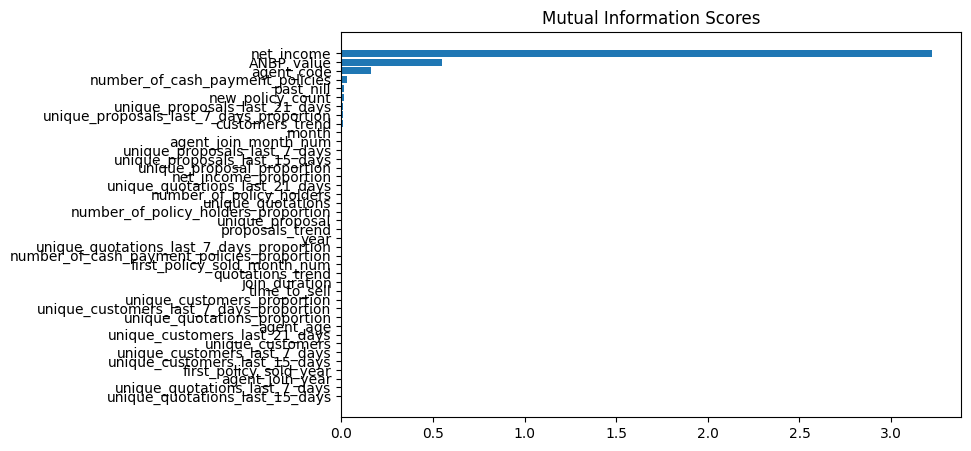

In [33]:
X = train_shifted.drop(columns=['next_month_new_policy_count'], axis=1)
y = train_shifted['next_month_new_policy_count']

mi_scores = make_mi_scores(X, y)

print(mi_scores)
# print(mi_scores.tail(20))  

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)
# plot_mi_scores(mi_scores.tail(20))

In [34]:
# top_columns = [
#     'net_income',
#     'ANBP_value',
#     'agent_code',
#     'number_of_cash_payment_policies',
#     'past_nill',
#     'new_policy_count',
#     'month',
#     'unique_quotations_proportion',
#     'unique_proposals_last_21_days',
#     'unique_proposal_proportion',
# ]

# # Keep only those columns in your train and test sets
# train_shifted = train_shifted[top_columns + ['next_month_new_policy_count']] 
# test_shifted = test_shifted[top_columns]

In [35]:
train_shifted

,agent_code,agent_age,unique_proposals_last_7_days,unique_proposals_last_15_days,unique_proposals_last_21_days,unique_proposal,unique_quotations_last_7_days,unique_quotations_last_15_days,unique_quotations_last_21_days,unique_quotations,...,unique_proposals_last_7_days_proportion,unique_proposal_proportion,unique_quotations_last_7_days_proportion,unique_quotations_proportion,unique_customers_last_7_days_proportion,unique_customers_proportion,number_of_cash_payment_policies_proportion,number_of_policy_holders_proportion,net_income_proportion,past_nill
8,0,35,2,2,0,8,0,0,0,2,...,0.002004,0.000713,0.000000,0.000224,0.001011,0.000494,0.000000,0.000260,0.002156,0
958,0,35,3,2,20,30,0,2,6,14,...,0.003080,0.002604,0.000000,0.001549,0.000985,0.001875,0.003267,0.002675,0.002774,0
1761,0,35,0,2,19,23,2,1,7,19,...,0.000000,0.001932,0.001569,0.001995,0.002050,0.001925,0.003432,0.000993,0.001925,0
2577,0,35,2,6,11,21,3,5,7,19,...,0.001885,0.001775,0.002224,0.001998,0.002022,0.001915,0.002531,0.002852,0.002413,0
2708,0,35,3,3,7,15,4,4,5,14,...,0.002924,0.001219,0.002933,0.001447,0.001925,0.001681,0.002518,0.000000,0.003037,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10976,904,32,2,6,7,17,1,6,9,17,...,0.001599,0.001156,0.000600,0.001440,0.000404,0.001443,0.000901,0.002126,0.000530,0
12008,904,32,0,6,12,23,0,4,4,21,...,0.000000,0.001547,0.000000,0.001780,0.000388,0.000830,0.000334,0.000000,0.001623,0
12950,904,32,2,6,5,14,1,6,1,12,...,0.001635,0.000939,0.000588,0.000983,0.001155,0.001312,0.002133,0.002029,0.000611,0
13905,904,32,1,1,20,27,0,1,6,22,...,0.000758,0.001729,0.000000,0.001791,0.000000,0.000814,0.002994,0.001215,0.000121,0


In [36]:
test_shifted

,agent_code,agent_age,unique_proposals_last_7_days,unique_proposals_last_15_days,unique_proposals_last_21_days,unique_proposal,unique_quotations_last_7_days,unique_quotations_last_15_days,unique_quotations_last_21_days,unique_quotations,...,unique_proposals_last_7_days_proportion,unique_proposal_proportion,unique_quotations_last_7_days_proportion,unique_quotations_proportion,unique_customers_last_7_days_proportion,unique_customers_proportion,number_of_cash_payment_policies_proportion,number_of_policy_holders_proportion,net_income_proportion,past_nill
0,784,43,0,2,12,17,4,5,1,14,...,0.000000,0.001074,0.002088,0.001100,0.002125,0.001410,0.000513,0.000000,0.000420,0.0
1,83,32,1,3,4,13,0,1,5,12,...,0.000710,0.000821,0.000000,0.000943,0.000708,0.000634,0.000598,0.000318,0.000266,0.0
2,326,52,2,6,17,27,3,4,4,21,...,0.001420,0.001706,0.001566,0.001650,0.001771,0.001480,0.000363,0.000000,0.001084,0.0
3,224,21,1,6,17,26,3,1,7,15,...,0.000710,0.001643,0.001566,0.001178,0.001063,0.001057,0.000353,0.000531,0.002122,1.0
4,232,33,0,4,2,8,3,4,6,14,...,0.000000,0.000505,0.001566,0.001100,0.001771,0.001057,0.000962,0.002122,0.000088,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909,501,55,2,1,11,16,4,2,2,15,...,0.001420,0.001011,0.002088,0.001178,0.001417,0.000987,0.000224,0.000495,0.001513,0.0
910,566,60,2,1,15,21,2,1,1,19,...,0.001420,0.001327,0.001044,0.001492,0.000708,0.000564,0.000834,0.000283,0.001294,0.0
911,542,45,3,5,14,27,2,0,4,23,...,0.002131,0.001706,0.001044,0.001807,0.001063,0.001057,0.002543,0.002122,0.002171,0.0
912,484,23,3,5,7,19,3,5,0,10,...,0.002131,0.001200,0.001566,0.000785,0.001063,0.000916,0.000598,0.000460,0.002234,1.0


In [37]:
import numpy as np
import pandas as pd
import gc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score, f1_score, precision_score

In [38]:
import joblib
import os

def get_model_predictions(X, y, df_test, model_func, params, model_name='model'):
    test_preds = np.zeros(len(df_test))
    val_preds = np.zeros(len(X))
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=9)

    # Ensure directory exists
    os.makedirs('models', exist_ok=True)

    for fold, (train_ind, valid_ind) in enumerate(cv.split(X, y)):
        X_train, y_train = X.iloc[train_ind], y[train_ind]
        X_val, y_val = X.iloc[valid_ind], y[valid_ind]

        model = model_func(**params)

        if model_func == lgb_model:
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                callbacks=[
                    lgb.early_stopping(stopping_rounds=50),
                    lgb.log_evaluation(100)
                ])
        elif model_func == xgb_model:
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                verbose=False
            )
        else:
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                early_stopping_rounds=50,
                verbose=False
            )    

        # Save model
        model_path = f"models/{model_name}_fold{fold}.pkl"
        joblib.dump(model, model_path)

        # Predictions
        y_pred_trn = model.predict(X_train)
        y_pred_val = model.predict(X_val)

        train_f1 = np.round(f1_score(y_train, y_pred_trn) * 100, 2)
        val_f1 = np.round(f1_score(y_val, y_pred_val) * 100, 2)

        print("-" * 50)
        print(model_func, "Fold:", fold, " Train F1:", train_f1, " Val F1:", val_f1)
        print("-" * 50)

        val_preds[valid_ind] = y_pred_val
        test_preds += model.predict(df_test) / cv.n_splits

        gc.collect()

    return val_preds, test_preds


In [39]:
def lgb_model(**params):
    return lgb.LGBMClassifier(**params)

def xgb_model(**params):
    return XGBClassifier(**params)

def catb_model(**params):
    return CatBoostClassifier(**params)

In [40]:
label = 'next_month_new_policy_count' 
X = train_shifted.drop(columns=[label], axis=1)  
y = train_shifted[label]

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

In [41]:
test_ = test_shifted.copy()
# results_ = test_shifted[label]

test_ = test_.reset_index(drop=True)
# results_ = results_.reset_index(drop=True)

In [51]:
lgb_params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'device': 'gpu',
    'verbose':-1
}

xgb_params = {
    'tree_method': 'gpu_hist',
    'device': 'gpu',
    'enable_categorical':True,
    'scale_pos_weight': (y == 0).sum() / (y == 1).sum()

}

catboost_params = {
    'grow_policy': 'SymmetricTree',
    'loss_function': 'Logloss',
    'eval_metric': 'Accuracy',  
    'task_type': 'GPU'
}

In [52]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

scaler = StandardScaler()

# Fit on training data
X_scaled_array = scaler.fit_transform(X)
test_scaled_array = scaler.transform(test_)

# Convert back to DataFrames
X_scaled = pd.DataFrame(X_scaled_array, columns=X.columns, index=X.index)
test_scaled = pd.DataFrame(test_scaled_array, columns=test_.columns, index=test_.index)

In [53]:
print("XGBClassifier")
xgb_val_preds, xgb_test_preds = get_model_predictions(X_scaled, y, test_scaled, xgb_model,xgb_params)

XGBClassifier
--------------------------------------------------
<function xgb_model at 0x7c280a38bce0> Fold: 0  Train F1: 97.65  Val F1: 89.04
--------------------------------------------------
--------------------------------------------------
<function xgb_model at 0x7c280a38bce0> Fold: 1  Train F1: 97.74  Val F1: 89.87
--------------------------------------------------
--------------------------------------------------
<function xgb_model at 0x7c280a38bce0> Fold: 2  Train F1: 97.48  Val F1: 87.84
--------------------------------------------------
--------------------------------------------------
<function xgb_model at 0x7c280a38bce0> Fold: 3  Train F1: 98.14  Val F1: 90.45
--------------------------------------------------
--------------------------------------------------
<function xgb_model at 0x7c280a38bce0> Fold: 4  Train F1: 97.87  Val F1: 88.9
--------------------------------------------------
--------------------------------------------------
<function xgb_model at 0x7c280a

--------------------------------------------------
********************
Validation MCC       : 0.0338
Validation Recall    : 88.12 %
Validation F1 Score  : 89.24 %
Validation Precision : 90.4 %
********************


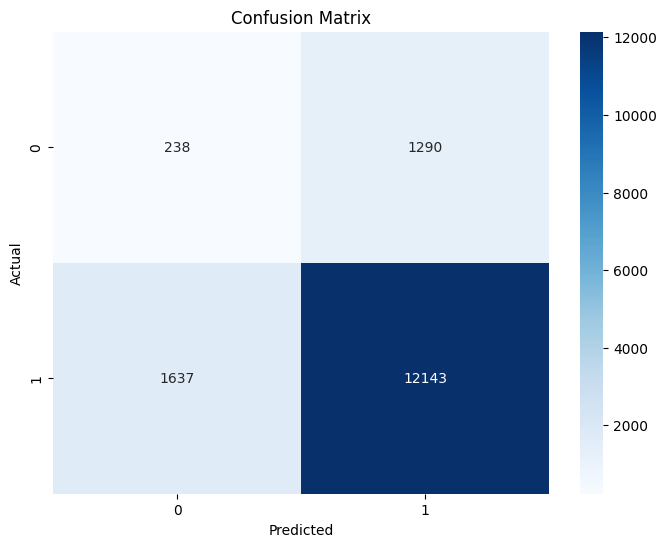

--------------------------------------------------


In [54]:
from sklearn.metrics import matthews_corrcoef, accuracy_score

# Calculate and print metrics on the validation set on LGBM
mcc = np.round(matthews_corrcoef(y, xgb_val_preds), 5)
recall = np.round(recall_score(y, xgb_val_preds) * 100, 2)
f1 = np.round(f1_score(y, xgb_val_preds) * 100, 2)
precision = np.round(precision_score(y, xgb_val_preds) * 100, 2)
print("-" * 50)

print('*' * 20)
print('Validation MCC       :', mcc)
print('Validation Recall    :', recall, '%')
print('Validation F1 Score  :', f1, '%')
print('Validation Precision :', precision, '%')
print('*' * 20)

# Draw the confusion matrix
cm = confusion_matrix(y, xgb_val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
gc.collect()

print("-" * 50)

In [55]:
xgb_test_preds

array([0.8, 0.9, 0.7, 1. , 1. , 0.7, 0.9, 0.8, 1. , 1. , 0.2, 0.9, 0. ,
       1. , 0.8, 1. , 0.8, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 0.9, 1. ,
       1. , 1. , 1. , 0.9, 1. , 0.5, 1. , 1. , 1. , 1. , 0.3, 1. , 1. ,
       0.6, 0.9, 1. , 1. , 0.8, 0.8, 0.3, 0.9, 0.8, 0.6, 1. , 0.9, 1. ,
       0.8, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 0.9, 1. ,
       1. , 0.9, 1. , 0.7, 1. , 0.9, 0.9, 0.7, 1. , 1. , 0.8, 0.9, 1. ,
       1. , 0.6, 1. , 0.9, 1. , 1. , 0.8, 0.9, 1. , 1. , 1. , 0.6, 1. ,
       1. , 0.4, 0.9, 0.7, 0.6, 1. , 0.9, 0.3, 1. , 0.6, 1. , 1. , 1. ,
       1. , 0.6, 1. , 0.5, 1. , 0.8, 1. , 0.8, 0.7, 0.8, 1. , 0.7, 0.8,
       0.8, 0.7, 1. , 0.9, 0.8, 0.9, 1. , 0.7, 1. , 1. , 1. , 0.8, 1. ,
       0.9, 0.9, 0.4, 0.7, 1. , 1. , 0.9, 1. , 1. , 1. , 0.9, 0.9, 0.8,
       1. , 0.9, 1. , 1. , 0.9, 1. , 1. , 0.8, 1. , 1. , 0.9, 0.9, 1. ,
       1. , 0.6, 1. , 0.6, 1. , 0.9, 1. , 1. , 1. , 1. , 0.8, 0.9, 0.6,
       1. , 1. , 0.1, 1. , 1. , 1. , 0.8, 0.7, 1. , 0.9, 0.4, 0.

In [66]:
xgb_test_preds_ = np.where(xgb_test_preds < 0.3, 0, 1)

In [67]:
sub['target_column'] = xgb_test_preds_.squeeze()

In [68]:
sub

,row_id,target_column
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1
...,...,...
909,910,1
910,911,1
911,912,1
912,913,1


In [69]:
sub.to_csv("submission.csv", index=False)